In [1]:
import cv2
import numpy as np
import dask as d
import matplotlib.pyplot as plt
import time

from glob import glob
from tensorflow import test, device
# from tensorflow import keras 
from tensorflow.keras import backend, Input, Model, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from fl_tissue_model_tools import defs, models

In [3]:
data_root_path = "D:/oxford_pets_data" # Carson
# data_root_path = "./" # Mitchell

In [4]:
img_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/images/*.jpg")])
label_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/annotations/trimaps/[!._]*.png")])

# Helper functions

In [5]:
def map2bin(lab, fg_vals, bg_vals, fg=1, bg=0):
    fg_mask = np.isin(lab, fg_vals)
    bg_mask = np.isin(lab, bg_vals)
    lab_c = lab.copy()
    lab_c[fg_mask] = fg
    lab_c[bg_mask] = bg
    return lab_c


def augment(img, rot, hflip, vflip, expand_dims=True):
    og_shape = img.shape
    hw = img.shape[:2]
    # Horizontal flip
    if hflip:
        img = cv2.flip(img, 1)
    # Vertical flip
    if vflip:
        img = cv2.flip(img, 0)
    # Rotation
    rot_mat = cv2.getRotationMatrix2D((hw[1] // 2, hw[0] // 2), rot, 1.0)
    
    if expand_dims:
        img = np.expand_dims(cv2.warpAffine(img, rot_mat, hw), 2)
    
    return img


def load_y(label_paths, img_size, fg_vals, bg_vals):
    y = np.zeros((len(label_paths),) + img_size + (1,), dtype=np.uint8)
    for j, path in enumerate(label_paths):
        # Use interpolation="nearest" to ensure mask is only valid bit values
        img = load_img(path, target_size=img_size, color_mode="grayscale", interpolation="nearest")
        # add a third dimension to the array
        img = np.expand_dims(img, 2)
        # Collapse the mask from three labels to two labels
        img = map2bin(img, fg_vals, bg_vals)
        y[j] = img
    return y

# Validate images match labels in order & count

In [6]:
def get_img_id(img_path):
    return img_path.split("/")[-1].split(".")[0]

In [7]:
assert(all([get_img_id(img_paths[i]) == get_img_id(label_paths[i]) for i in range(len(img_paths))]))

In [8]:
assert(len(img_paths) == len(label_paths))
print(len(img_paths))

7390


# Constants

In [9]:
rand_seed = 12345
batch_size = 32
img_shape = (128, 128)
# img_size = (160, 160)
# num_classes = 2
n_outputs = 1
rs = np.random.RandomState(seed=rand_seed)
# For collapsing mask into binary range
fg_vals = [1, 3]
bg_vals = [2]
cp_filepath = "oxford_pets_segmentation_best_weights.h5"

# Examine data

In [10]:
preview_idx = 10

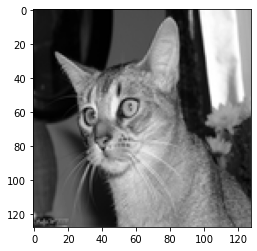

In [11]:
# img = cv2.imread(img_paths[preview_idx], cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(np.array(load_img(img_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="lanczos")), 2)
plt.imshow(img, cmap="gray")
plt.show()

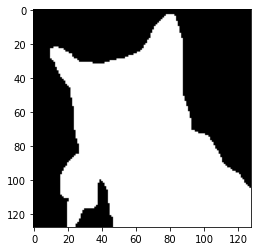

In [12]:
mask = np.expand_dims(
    np.array(load_img(label_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="nearest")), 2
)
mask = map2bin(mask, fg_vals, bg_vals)
plt.imshow(mask, cmap="gray")
plt.show()

In [13]:
np.unique(mask)

array([0, 1], dtype=uint8)

# Data pipeline

In [14]:
class OxfordPetsSequence(Sequence):
    """Helper to iterate over the data"""
    # TODO: edit to turn off augmentations for validation 
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, random_state, fg_vals, bg_vals, sample_weights=None, augmentation_function=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.rs: np.random.RandomState = random_state
        self.fg_vals = fg_vals
        self.bg_vals = bg_vals
        self.sample_weights = sample_weights
        if sample_weights:
            self.fg_weight = sample_weights[0]
            self.bg_weight = sample_weights[1]
        self.augmentation_function = augmentation_function


    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        # Image index, offset by batch
        i = idx * self.batch_size 
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        # Load the input images and convert them to grayscale
        def load_x():
            x = np.zeros((len(batch_input_img_paths),) + self.img_size + (1,), dtype=np.float32)
            for j, path in enumerate(batch_input_img_paths):
                # Ensure best quality downsampling (interpolation methods overview: https://stackoverflow.com/a/44083113)
                img = load_img(path, target_size=self.img_size, color_mode="grayscale", interpolation="lanczos")
                img = np.expand_dims(img, 2) # add a third dimension to the array
                x[j] = img
            return x

        # load the target images and condense the number of labels in the segmentation mask
        def load_y():
            y = np.zeros((len(batch_target_img_paths),) + self.img_size + (1,), dtype=np.uint8)
            for j, path in enumerate(batch_target_img_paths):
                # Use interpolation="nearest" to ensure mask is only valid bit values
                img = load_img(path, target_size=self.img_size, color_mode="grayscale", interpolation="nearest")
                # add a third dimension to the array
                img = np.expand_dims(img, 2)
                # Collapse the mask from three labels to two labels
                img = map2bin(img, self.fg_vals, self.bg_vals)
                y[j] = img
            return y

        x, y = d.compute((d.delayed(load_x)(), d.delayed(load_y)()))[0]
        
        if self.augmentation_function != None:
            m = len(x)
            # Cannot parallelize (random state ensures reproducibility)
            rots = self.rs.choice([0, 90, 180, 270], size=m)
            hflips = self.rs.choice([True, False], size=m)
            vflips = self.rs.choice([True, False], size=m)

            def aug_imgs(imgs):
                return np.array([self.augmentation_function(imgs[i], rots[i], hflips[i], vflips[i]) for i in range(m)])
            
            x, y = d.compute((d.delayed(aug_imgs)(x), d.delayed(aug_imgs)(y)))[0]
        
        if self.sample_weights:
            sample_weights = np.zeros(shape=y.shape)
            sample_weights[y == 1] = self.fg_weight
            sample_weights[y != 1] = self.bg_weight
            return x, y, sample_weights
            
        return x, y

# Data generator demo

0.14799761772155762


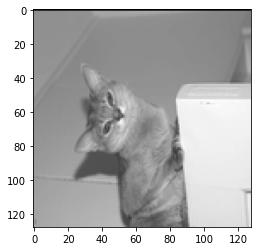

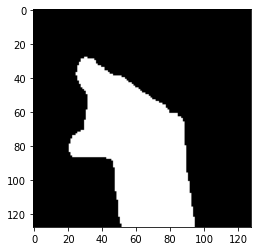

In [15]:
pets_demo = OxfordPetsSequence(batch_size, img_shape, img_paths, label_paths, rs, fg_vals, bg_vals, augmentation_function=augment)
start = time.time()
X, y = pets_demo[1]
stop = time.time()
print(stop - start)
plt.imshow(X[1][:,:,0], cmap='gray')
plt.show()
plt.imshow(y[1][:,:,0], cmap='gray')
plt.show()

# Set up data generators

In [16]:
n_val = int(len(img_paths) * 0.2)
n_test = int(len(img_paths) * 0.2)
# Shuffle data
data_idx = np.array(range(len(img_paths)))
rs.shuffle(data_idx)

In [17]:
train_img_paths = img_paths[: -(n_val + n_test)]
train_label_paths = label_paths[: -(n_val + n_test)]

val_img_paths = img_paths[-(n_val + n_test): -n_test]
val_label_paths = label_paths[-(n_val + n_test): -n_test]

test_img_paths = img_paths[-n_test:]
test_label_paths = label_paths[-n_test:]

In [18]:
y_train_labels = load_y(train_label_paths, img_shape, fg_vals, bg_vals)
# Weight should be the inverse of prevalence
n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}

In [20]:
train_gen = OxfordPetsSequence(batch_size, img_shape, train_img_paths, train_label_paths, rs, fg_vals, bg_vals, augmentation_function=augment, sample_weights=sample_weights)
val_gen = OxfordPetsSequence(batch_size, img_shape, val_img_paths, val_label_paths, rs, fg_vals, bg_vals, augmentation_function=augment, sample_weights=sample_weights)
# No augmentation for test_gen
test_gen = OxfordPetsSequence(batch_size, img_shape, test_img_paths, test_label_paths, rs, fg_vals, bg_vals)

# Build and train model

In [21]:
### create the model ###
backend.clear_session()
# model = get_oxford_pets_model(img_size, n_classes)
# model = get_oxford_pets_model(img_size, n_outputs)
model = models.build_UNetXception(
    n_outputs,
    img_shape,
    filter_counts=(32, 64, 128, 256),
    # filter_counts=(16, 32, 64, 128),
    output_act="sigmoid"
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
# tell tf to use the gpu
# import tensorflow as tf
device(test.gpu_device_name())

In [25]:
test.gpu_device_name()

'/device:GPU:0'

In [26]:
### train the model ###
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="rmsprop", loss="binary_crossentropy")
callbacks = [ModelCheckpoint(cp_filepath, save_best_only=True, save_weights_only=True)]
num_epochs = 15
h = model.fit(train_gen, validation_data=val_gen, epochs=num_epochs, callbacks=callbacks)

Epoch 1/15
138/138 [==============================] - 34s 186ms/step - loss: 0.7919 - val_loss: 2.6914
Epoch 2/15
138/138 [==============================] - 25s 182ms/step - loss: 0.4626 - val_loss: 2.3764
Epoch 3/15
138/138 [==============================] - 25s 180ms/step - loss: 0.4033 - val_loss: 1.5923
Epoch 4/15
138/138 [==============================] - 25s 181ms/step - loss: 0.3827 - val_loss: 0.4140
Epoch 5/15
138/138 [==============================] - 25s 182ms/step - loss: 0.3596 - val_loss: 0.4154
Epoch 6/15
138/138 [==============================] - 25s 181ms/step - loss: 0.3472 - val_loss: 0.3951
Epoch 7/15
138/138 [==============================] - 25s 182ms/step - loss: 0.3352 - val_loss: 0.3959
Epoch 8/15
138/138 [==============================] - 25s 182ms/step - loss: 0.3240 - val_loss: 0.3026
Epoch 9/15
138/138 [==============================] - 25s 181ms/step - loss: 0.3167 - val_loss: 0.3072
Epoch 10/15
138/138 [==============================] - 27s 195ms/step - l

# Load best weights

In [27]:
model.load_weights(cp_filepath)

In [28]:
# Generate predictions for all images in the test set
# val_gen = OxfordPetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
test_preds = model.predict(test_gen)

In [39]:
# pred = np.argmax(test_preds[pred_idx], axis=-1)
pred_idx = 221
pred = np.copy(test_preds[pred_idx])
pred[pred < 0.7] = 0
pred[pred > 0] = 1
# true = test_img_paths[pred_idx]
true = np.expand_dims(np.array(load_img(test_img_paths[pred_idx], target_size=img_shape, color_mode="grayscale", interpolation="lanczos")), 2)

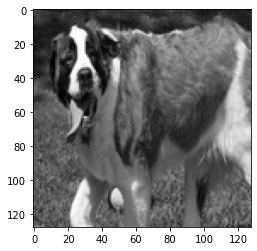

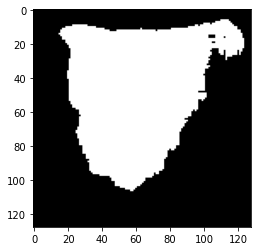

In [40]:
plt.imshow(true, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()
plt.imshow(pred * defs.GS_MAX, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()